In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import torch.nn.functional as F
import random
import csv

In [ ]:
# Install kaggle if not installed
!pip install -q kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

# Move kaggle.json to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d usmanshams/tbx-11

# Unzip dataset
!unzip tbx-11.zip -d tbx-11

# Import necessary libraries
import os
import csv
import random
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths correctly
base_path = 'tbx-11/TBX11K/imgs'
tbImg_path = os.path.join(base_path, 'tb')  # Changed from 'sick' to 'tb'
healthyImg_path = os.path.join(base_path, 'health')

# Check if directories exist
if not os.path.exists(tbImg_path) or not os.path.exists(healthyImg_path):
    raise FileNotFoundError("Dataset folders not found. Please check dataset structure.")

# Prepare dataset CSV file
fields = ['ImgName', 'Label']
filename = 'dataset.csv'
out_path = './'
filepath = os.path.join(out_path, filename)
data = []

# Load TB images
tb_images = [i for i in os.listdir(tbImg_path) if i[0] != '.']
healthy_images = [i for i in os.listdir(healthyImg_path) if i[0] != '.']

tb_count = len(tb_images)
healthy_count = len(healthy_images)
print(f"TB Images: {tb_count}, Healthy Images: {healthy_count}")

# Data augmentation for TB images
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

augmented_tb_images = []
num_augmented = healthy_count - tb_count  # Number of images needed to balance
print(f"Generating {num_augmented} augmented TB images...")

for img_name in tb_images:
    if len(augmented_tb_images) >= num_augmented:
        break
    img_path = os.path.join(tbImg_path, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)  # Reshape for generator

    i = 0
    for batch in datagen.flow(image, batch_size=1, save_prefix='aug', save_format='jpeg'):
        aug_img_name = f"aug_{i}_{img_name}"
        aug_img_path = os.path.join(tbImg_path, aug_img_name)
        cv2.imwrite(aug_img_path, batch[0])
        augmented_tb_images.append(aug_img_name)
        i += 1
        if len(augmented_tb_images) >= num_augmented:
            break

# Add original and augmented TB images to dataset
data.extend([[i, 1] for i in tb_images])
data.extend([[i, 1] for i in augmented_tb_images])

# Add healthy images
data.extend([[i, 0] for i in healthy_images])

random.shuffle(data)

# Write to CSV
with open(filepath, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(data)

print("CSV file created successfully at:", filepath)


Streaming output truncated to the last 5000 lines.
  inflating: tbx-11/TBX11K/imgs/sick/s3833.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3834.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3835.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3836.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3837.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3838.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3839.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3840.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3841.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3842.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3843.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3844.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3846.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3847.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3848.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3853.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3854.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3855.png  
  inflating: tbx-11/TBX11K/imgs/sick/s3857.png  
  inflating: tbx-1

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset CSV
df = pd.read_csv('dataset.csv')

# Splitting into train and test datasets
msk = np.random.rand(len(df)) <= 0.8
train_df = df[msk]
test_df = df[~msk]

# Save the split datasets
train_df.to_csv('train_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)

print("Train and test datasets saved successfully!")


Train and test datasets saved successfully!


In [ ]:
train_df.head()

,ImgName,Label
0,h0958.png,0
3,aug_2156_tb0045.png,1
4,aug_1860_tb0045.png,1
5,aug_318_tb0045.png,1
6,h1099.png,0


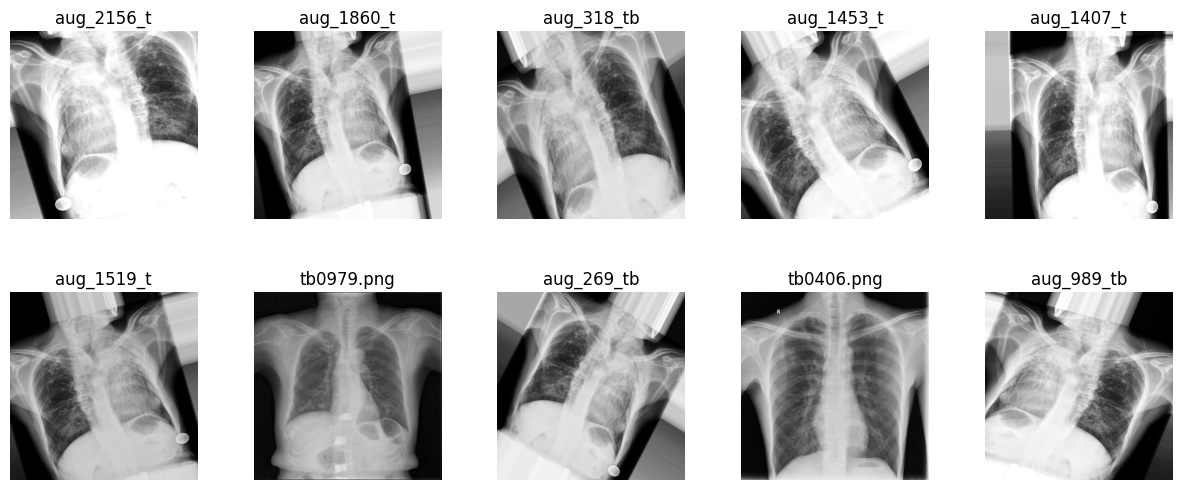

In [ ]:
import matplotlib.pyplot as plt
# Load the dataset CSV
df = pd.read_csv('train_dataset.csv')

# TB images (infected images)
path_to_images = tbImg_path  # Updated from infectedImg_path to tbImg_path

# Filter TB images (starting with 'aug_' or original)
filtered_df = df[df['Label'] == 1].head(10)  # Selecting TB (infected) images

num_images = len(filtered_df)
num_rows = 2
num_cols = num_images // num_rows + (num_images % num_rows > 0)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, (index, row) in enumerate(filtered_df.iterrows()):
    img_name = row['ImgName']
    img_path = os.path.join(path_to_images, img_name)  # Use os.path.join for compatibility
    image = Image.open(img_path)
    ax = axs[i // num_cols, i % num_cols]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(img_name[:10])

# Hide empty subplots
for i in range(num_images, num_rows * num_cols):
    axs.flatten()[i].axis('off')

plt.show()

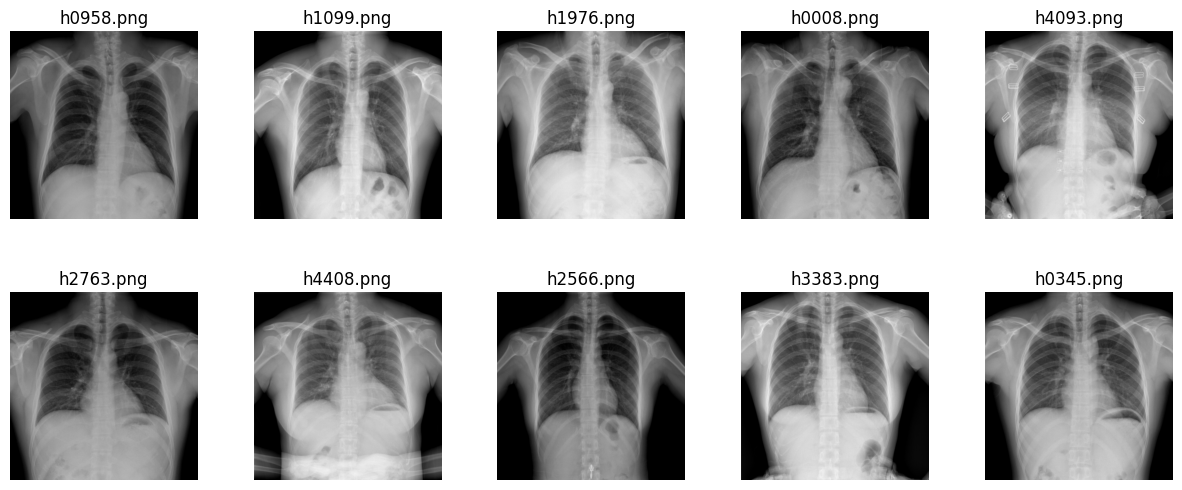

In [ ]:
df = pd.read_csv('train_dataset.csv')

# Healthy images
path_to_images = healthyImg_path

# Filter healthy images (labeled as 0 in the dataset)
filtered_df = df[df['Label'] == 0].head(10)

num_images = len(filtered_df)
num_rows = 2
num_cols = num_images // num_rows + (num_images % num_rows > 0)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, (index, row) in enumerate(filtered_df.iterrows()):
    img_name = row['ImgName']
    img_path = os.path.join(path_to_images, img_name)  # Use os.path.join for proper path handling
    image = Image.open(img_path)
    ax = axs[i // num_cols, i % num_cols]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(img_name[:10])

# Hide empty subplots
for i in range(num_images, num_rows * num_cols):
    axs.flatten()[i].axis('off')

plt.show()

In [ ]:
class TBClassificationDataset(Dataset):
    def __init__(self, dataFrame, root_dir, transform=None):
        self.dataFrame = dataFrame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataFrame)

    def __getitem__(self, idx):
        label = self.dataFrame.iloc[idx, 1]

        # Updated to match new directory structure
        if label == 0:
            newDir = os.path.join(self.root_dir, 'health')
        elif label == 1:
            newDir = os.path.join(self.root_dir, 'tb')  # Changed from 'sick' to 'tb'

        img_name = os.path.join(newDir, self.dataFrame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define image transformations
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match DenseNet & ViT input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize for pre-trained models
])

In [ ]:
# Creating train and test datasets
tb_train = TBClassificationDataset(dataFrame=train_df, root_dir=base_path,transform=img_transform)
tb_test = TBClassificationDataset(dataFrame=test_df, root_dir=base_path,transform=img_transform)

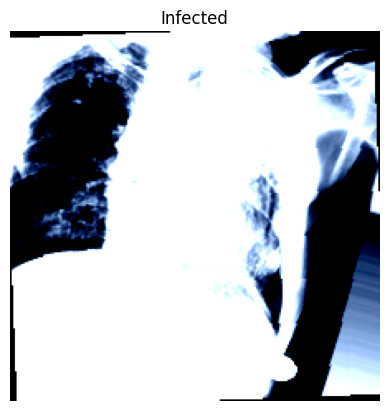

In [ ]:
# Get an image and its label from the dataset
temp_img, temp_lab = tb_train[1]

# Convert image tensor to a format suitable for plotting (if needed)
if isinstance(temp_img, Image.Image):
    temp_img = transforms.ToTensor()(temp_img)  # Convert PIL image to tensor if necessary

# Convert tensor to numpy for visualization
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))

# Set title based on label
plt.title("Infected" if temp_lab == 1 else "Healthy")
plt.axis('off')
plt.show()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_loader = DataLoader(dataset=tb_train, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=tb_test, batch_size=4, shuffle=False)

In [ ]:
import torchvision.models as models
import torch.nn as nn

class DenseNet121TB(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(DenseNet121TB, self).__init__()

        # Load DenseNet-121 model with correct weights
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        self.densenet = models.densenet121(weights=weights)

        # Modify the classifier to fit the TB classification task
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

# Example Usage
model = DenseNet121TB(num_classes=2, pretrained=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 116MB/s]


In [ ]:
from transformers import ViTModel, ViTImageProcessor

class ViT_DenseNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ViT_DenseNet, self).__init__()

        # Load DenseNet-121 as feature extractor
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        self.densenet = models.densenet121(weights=weights)
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # Remove DenseNet classifier

        # Load Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

        vit_features = 768  # ViT output dimension

        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(in_features + vit_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract DenseNet features
        x_densenet = self.densenet(x)

        # Preprocess input for ViT
        inputs = self.vit_processor(images=x, return_tensors="pt")
        x_vit = self.vit(**inputs).last_hidden_state[:, 0, :]  # CLS token

        # Ensure same device for concatenation
        x_vit = x_vit.to(x_densenet.device)

        # Concatenate features
        x = torch.cat((x_densenet, x_vit), dim=1)
        return self.classifier(x)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel, ViTImageProcessor

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ViT_DenseNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ViT_DenseNet, self).__init__()

        # Load DenseNet-121 as feature extractor
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        self.densenet = models.densenet121(weights=weights)
        in_features_densenet = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()  # Remove classifier

        # Load Vision Transformer (ViT)
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
        vit_features = 768  # ViT CLS token output size

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features_densenet + vit_features, 500),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(500, num_classes)
        )

    def forward(self, x):
        # Extract DenseNet features
        x_densenet = self.densenet(x)

        # Preprocess input for ViT
        inputs = self.vit_processor(images=x, return_tensors="pt")
        inputs = {k: v.to(x_densenet.device) for k, v in inputs.items()}  # Ensure correct device
        x_vit = self.vit(**inputs).last_hidden_state[:, 0, :]  # CLS token

        # Concatenate features
        x = torch.cat((x_densenet, x_vit), dim=1)
        return self.classifier(x)
    def forward(self, x):
      # Extract DenseNet features
      x_densenet = self.densenet(x)

      # De-normalize input for ViT
      x_vit_input = x * torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)  # Unscale
      x_vit_input += torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)  # Re-add mean
      x_vit_input = x_vit_input.clamp(0, 1)  # Ensure values are in [0,1]

      # Extract ViT features
      x_vit = self.vit(x_vit_input).last_hidden_state[:, 0, :]  # CLS token

      # Concatenate both feature sets
      x = torch.cat((x_densenet, x_vit), dim=1)
      return self.classifier(x)


# Initialize model
model = ViT_DenseNet(num_classes=2, pretrained=True).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with AMSGrad
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500, 2000, 2500], gamma=0.5)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
num_ep = 10
n_steps = len(train_loader)  # Total batches per epoch
epoch_losses = []
train_accuracies = []
val_accuracies = []

for ep in range(num_ep):
    model.train()
    epoch_loss = 0.0
    tr_correct = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.long().to(device)  # Ensure labels are of type long

        # Forward Pass
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        epoch_loss += loss.item()

        # Backward Pass
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        pred = torch.argmax(output, dim=1)
        tr_correct += (pred == labels).sum().item()
        total_train += labels.size(0)

    # Calculate average loss and training accuracy for this epoch
    avg_epoch_loss = epoch_loss / (i + 1)  # Use number of batches instead of n_steps
    epoch_losses.append(avg_epoch_loss)

    tr_acc = 100 * tr_correct / total_train
    train_accuracies.append(tr_acc)

    # Validation phase
    model.eval()
    val_correct = 0
    total_val = 0
    for images, labels in test_loader:  # Fixed variable name
        with torch.no_grad():
            images = images.to(device)
            labels = labels.long().to(device)  # Ensure correct data type
            output = model(images)
            pred = torch.argmax(output, dim=1)
            val_correct += (pred == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation accuracy
    val_acc = 100 * val_correct / total_val
    val_accuracies.append(val_acc)

    # Update learning rate
    scheduler.step()

    print(f'Epoch: [{ep + 1}/{num_ep}], Loss: {avg_epoch_loss:.4f}, Train Accuracy: {tr_acc:.2f}, Validation Accuracy: {val_acc:.2f}')



Epoch: [1/10], Loss: 0.2682, Train Accuracy: 90.84, Validation Accuracy: 96.16
Epoch: [2/10], Loss: 0.2021, Train Accuracy: 93.30, Validation Accuracy: 98.38
Epoch: [3/10], Loss: 0.1541, Train Accuracy: 94.47, Validation Accuracy: 95.89
Epoch: [4/10], Loss: 0.1267, Train Accuracy: 95.75, Validation Accuracy: 95.49
Epoch: [5/10], Loss: 0.0939, Train Accuracy: 97.04, Validation Accuracy: 98.52
Epoch: [6/10], Loss: 0.0677, Train Accuracy: 97.91, Validation Accuracy: 98.72
Epoch: [7/10], Loss: 0.0738, Train Accuracy: 97.51, Validation Accuracy: 98.99
Epoch: [8/10], Loss: 0.0518, Train Accuracy: 98.35, Validation Accuracy: 99.06
Epoch: [9/10], Loss: 0.0511, Train Accuracy: 98.43, Validation Accuracy: 98.59
Epoch: [10/10], Loss: 0.0469, Train Accuracy: 98.58, Validation Accuracy: 98.72


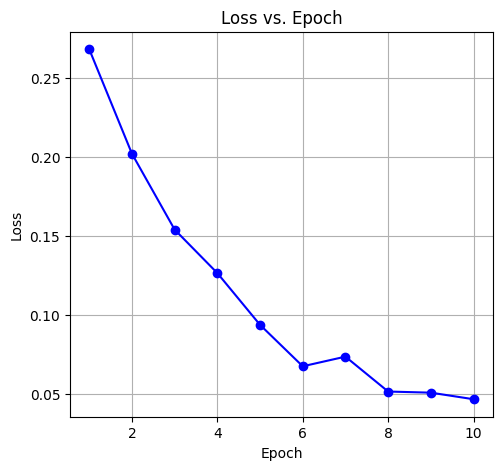

In [ ]:
plt.figure(figsize=(12, 5))

# Plot Loss vs. Epoch
plt.subplot(1, 2, 1)
plt.plot(range(1, num_ep + 1), epoch_losses, marker='o', linestyle='-', color='blue')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


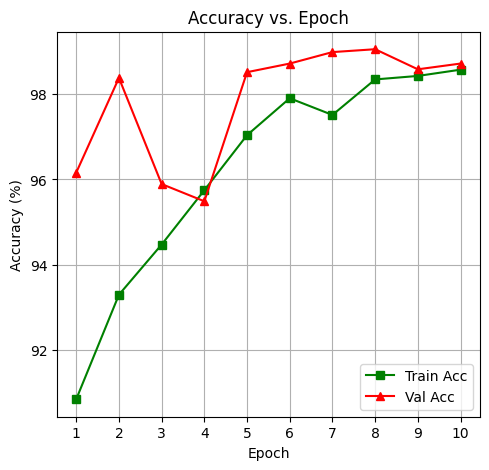

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(1, num_ep + 1), train_accuracies, marker='s', linestyle='-', color='green', label='Train Acc')
plt.plot(range(1, num_ep + 1), val_accuracies, marker='^', linestyle='-', color='red', label='Val Acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_ep + 1))

# Show plots
plt.show()

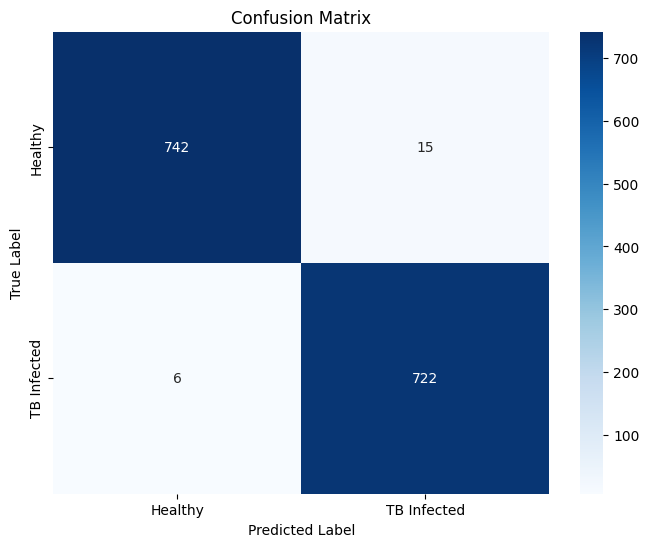

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define class names
class_names = ["Healthy", "TB Infected"]

# Store true labels and predicted labels
y_true = []
y_pred = []

# Model evaluation
model.eval()
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)  # Ensure labels are on the same device

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    y_pred.extend(predicted.cpu().tolist())  # Move to CPU before converting to list
    y_true.extend(labels.cpu().tolist())  # Move to CPU before converting to list

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Set rectangular shape
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred) * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 98.59%


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(y_true, y_pred) * 100
print(f'Precision: {precision:.2f}%')


Precision: 97.96%


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred) * 100
print(f'F1-Score: {f1:.2f}%')


F1-Score: 98.57%


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()
specificity = (TN / (TN + FP)) * 100
print(f'Specificity: {specificity:.2f}%')


Specificity: 98.02%
